In [1]:
import numpy as np
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
import Config

In [2]:
conditions = Config.conditions
galaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'

In [3]:
measGalaFile = galaDir + 'Blue_Meas_Galaxies.fits'

In [4]:
data = fitsio.read(measGalaFile)

In [5]:
res = 512
pixFile = galaDir + 'Valid_'+str(res)+'_Pixels.fits'

In [6]:
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

## This is the minimum magnitude that is used.

In [7]:
magCutoff = 24

In [8]:
galaRA = data['RA']
galaDEC = data['DEC']
galaGMAG = data['GMAG']
galaSOFCLASS = data['CLASS']
galaPIXRepeats = hp.ang2pix(res, galaRA, galaDEC, lonlat = True, nest = True)

galaSOFCLASS = galaSOFCLASS[np.where((pixCheck[galaPIXRepeats]) & (galaGMAG > magCutoff))[0]]
galaCLASSRepeats = np.zeros_like(galaSOFCLASS)
galaCLASSRepeats[np.where(galaSOFCLASS >= 2)[0]] = 1
galaPIXRepeats = galaPIXRepeats[np.where((pixCheck[galaPIXRepeats]) & (galaGMAG > magCutoff))[0]]

In [9]:
sortInds = galaPIXRepeats.argsort()
galaPIXRepeats = galaPIXRepeats[sortInds[::1]]
galaCLASSRepeats = galaCLASSRepeats[sortInds[::1]]

In [10]:
uniqInd = 0
galaInd = 0

# This will be used to store the number of stars at each pixel.
galaPIX = np.unique(galaPIXRepeats) # The unique pixels, with no repeats.
galaCOR = np.zeros_like(galaPIX) # Correctly classified galaxies per pixel
galaALL = np.zeros_like(galaPIX) # All galaxy injections per pixel.

while galaInd < len(galaPIXRepeats):
    if galaPIX[uniqInd] == galaPIXRepeats[galaInd]: # If the pixels match up in the arrays.
        galaCOR[uniqInd] += galaCLASSRepeats[galaInd] # Add one if there was a galaxy at this location.
        galaALL[uniqInd] += 1                # Add one to the corresponding spot in the galaAll.
        galaInd += 1                         # Add one to the starInd to see if the next index in starPix is same.
        # Since the last index of galaPix and galaPixRepeats are the same, galaInd will increase 
        # the last time through the loop, making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the galaPix array.

In [11]:
conditions = Config.conditions
for cond in conditions:
    if 'FWHM' in cond:
        print(cond)
FWHM = 'FWHM Fluxrad Weighted Mean, r Band'
FWHMFile = galaDir + str(res) + '_' + FWHM + '.fits'

FWHM Weighted Mean, g Band
FWHM Weighted Mean, r Band
FWHM Weighted Mean, i Band
FWHM Weighted Mean, z Band
FWHM Minimum, g Band
FWHM Minimum, r Band
FWHM Minimum, i Band
FWHM Minimum, z Band
FWHM Maximum, g Band
FWHM Maximum, r Band
FWHM Maximum, i Band
FWHM Maximum, z Band
FWHM Fluxrad Weighted Mean, g Band
FWHM Fluxrad Weighted Mean, r Band
FWHM Fluxrad Weighted Mean, i Band
FWHM Fluxrad Weighted Mean, z Band
FWHM Fluxrad Minimum, g Band
FWHM Fluxrad Minimum, r Band
FWHM Fluxrad Minimum, i Band
FWHM Fluxrad Minimum, z Band
FWHM Fluxrad Maximum, g Band
FWHM Fluxrad Maximum, r Band
FWHM Fluxrad Maximum, i Band
FWHM Fluxrad Maximum, z Band


In [12]:
condData = fitsio.read(FWHMFile) # This reads in the data
condSigExt = np.full(12*(res**2), -1.6375e+30) # Gives a default value
condSigExt[validPix] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals
condSigExt[np.where(condSigExt == -1.6375e+30)[0]] = hp.UNSEEN # Masks all non valid pixels
balrFWHMMap = condSigExt[galaPIX] # Only stores the values that are in pixels with injections

In [13]:
import matplotlib.pyplot as plt

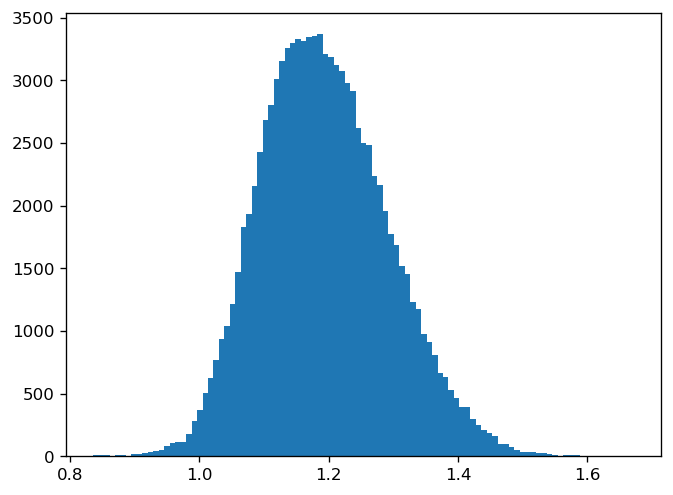

In [14]:
plt.figure(dpi = 120)
plt.hist(balrFWHMMap, bins = np.linspace(np.min(balrFWHMMap), np.max(balrFWHMMap), 100))
plt.show()

In [15]:
stanMap = (balrFWHMMap - np.average(balrFWHMMap)) / np.std(balrFWHMMap)

In [16]:
sigma = 0.5
numBins = 100

In [17]:
x = np.linspace(-3, 3, numBins) # xValues for plot, goes out to 3 standard deviation.
y = []

for xi in x:
    # Gaussian weighting the values close by to each x value.
    totCor = np.sum(galaCOR * np.exp(-1*(((stanMap.astype(float) - xi) / sigma)**2)))
    totAll = np.sum(galaALL * np.exp(-1*(((stanMap.astype(float) - xi) / sigma)**2)))
    y.append(totCor / totAll)

y = np.array(y)

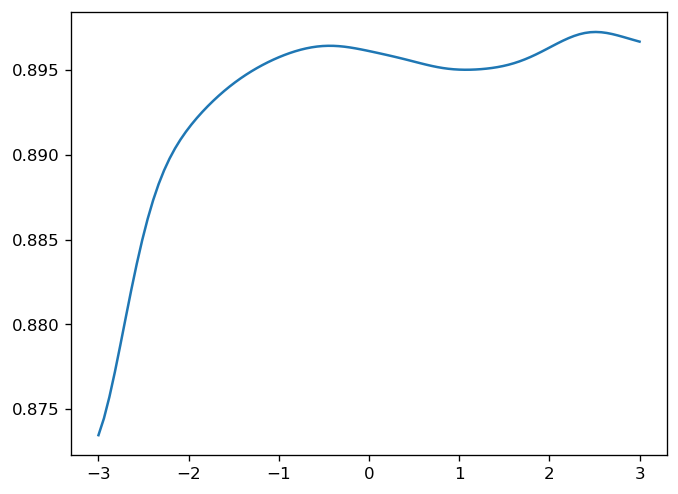

In [18]:
plt.figure(dpi = 120)
plt.plot(x, y)
plt.show()